# Phase estimation algorithm

In this section we will look into the [phase estimation algorithm](https://en.wikipedia.org/wiki/Quantum_phase_estimation_algorithm), a necessary sub-routine in many quantum algorithms. The phase estimation algorithm allows us to estimate the eigenvalues of a given unitary operator. As the eigenvalues $\lambda$ of a unitary operator lie on the unit circle, they can be characterised solely by the phase $\theta$. 

Recall that a unitary operator $\hat{U}$ can be written in terms of a Hermitian operator $\hat{A}$ such that:

$$ \hat{U}|\Psi\rangle = e^{it\hat{A}}|\Psi\rangle. $$

If $|x\rangle$ is an eigenstate of $\hat{U}$, then:

$$ \hat{U}|x\rangle = \lambda|x\rangle = e^{2\pi i t \theta}|x\rangle, $$

and $\theta$ is additionally the eigenvalues of $\hat{A}$ with eigenstate $|x\rangle$, and where I have included the additional time evolution parameter $t$.

Phase estimation begins with two registers, one with the eigenstate $|x\rangle$, and the other we will use to estimate the phase, which we initialize into an initial superposition of $n$ qubits:

$$ |0\rangle^{\otimes n}|x\rangle \rightarrow \frac{1}{\sqrt{2^{n}}}\sum^{2^{n}-1}_{j=0}|j\rangle|x\rangle $$.

We can then perfrom a series of $n$ controlled rotations $\hat{U}^{-2^{k}}$ for $k=0,\dots,n-1$, resulting in the state:

$$ \frac{1}{\sqrt{2^{n}}}\sum^{2^{n}-1}_{j=0}|j\rangle|x\rangle \rightarrow \frac{1}{\sqrt{2^{n}}}\sum^{2^{n}-1}_{j=0}e^{-2\pi i t \theta j}|j\rangle|x\rangle. $$.

The number of qubits $n$ should scale inversely with the conditioning number $\kappa$ of $\hat{A}$, equal to the ratio of the largest and smallest eigenvalues $\kappa=\theta_{max}/\theta_{min}$.
By now applying the inverse quantum Fourier transform onto the phase register, we recover the eigenvalues:

$$ \frac{1}{\sqrt{2^{n}}}\sum^{2^{n}-1}_{j=0}e^{-2\pi i t \theta j}|j\rangle|x\rangle \rightarrow \frac{1}{2^{n}}\sum^{2^{n}-1}_{j=0}e^{-2\pi i t \theta j}\sum^{2^{n}-1}_{k=0}e^{\frac{2\pi ijk}{2^{n}}}|k\rangle|x\rangle $$

such that:

$$ \frac{1}{2^{n}}\sum^{2^{n}-1}_{j=0}e^{-2\pi i t \theta j}\sum^{2^{n}-1}_{k=0}e^{\frac{2\pi ijk}{2^{n}}}|k\rangle|x\rangle = \frac{1}{2^{n}}\sum^{2^{n}-1}_{j=0}\sum^{2^{n}-1}_{k=0}e^{\frac{2\pi ij}{2^{n}}(k-2^{n}t\theta)}|k\rangle|x\rangle $$.

This result strongly peaks at $k=\lfloor2^{n}t\theta\rfloor$, where $t$ can be chosen to avoid overflow errors. It can be shown that the measurement of the phase register will return the desired result at the given precision with probability greater than $4/\pi^2$.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.circuit.library import PhaseGate
from qiskit.extensions import HamiltonianGate
from qiskit.quantum_info import random_hermitian
import qiskit_tools as qt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from qiskit.circuit.library import QFT

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
width=0.75
color='black'
fontsize=28
ticksize=22
figsize=(10,8)

In [3]:
A = random_hermitian(2).to_matrix()
print(A)

[[ 1.28702683+0.j         -0.1494534 +0.01243272j]
 [-0.1494534 -0.01243272j  0.26207661+0.j        ]]


In [4]:
def get_delta(n_l, lambda_min, lambda_max):
    formatstr = "#0" + str(n_l + 2) + "b"
    lambda_min_tilde = np.abs(lambda_min * (2**n_l - 1) / lambda_max)
    # floating point precision can cause problems
    if np.abs(lambda_min_tilde - 1) < 1e-7:
        lambda_min_tilde = 1
    binstr = format(int(lambda_min_tilde), formatstr)[2::]
    lamb_min_rep = 0
    for i, char in enumerate(binstr):
        lamb_min_rep += int(char) / (2 ** (i + 1))
    return lamb_min_rep

In [5]:
phase = True

lambda_min = np.min(np.abs(np.linalg.eigvals(A)))
lambda_max = np.max(np.abs(np.linalg.eigvals(A)))
kappa = np.abs(lambda_max/lambda_min)

nanc = np.max([int(np.log2(A.shape[0])) + 1, int(np.ceil(np.log2(kappa + 1)))]) + phase
nanc = 3*nanc

scaling = get_delta(nanc - phase, lambda_min, lambda_max)
t0 = scaling / (lambda_min * (2**phase))
t = 2 * np.pi * t0

print(t, scaling, nanc, kappa, lambda_min, lambda_max)

2.397403842092332 0.18359375 12 5.438932187103872 0.24058390418763143 1.3085195401852225


In [6]:
nx = int(np.log2(A.shape[0]))

In [7]:
qreg = QuantumRegister(nx, 'x')
qanc = QuantumRegister(nanc, 'anc')
circ = QuantumCircuit(qreg, qanc)

In [8]:
A_gate = HamiltonianGate(A, t)

In [9]:
circ.h(qreg[0]);
circ = qt.PhaseEst(circ, qreg, qanc, A_gate)

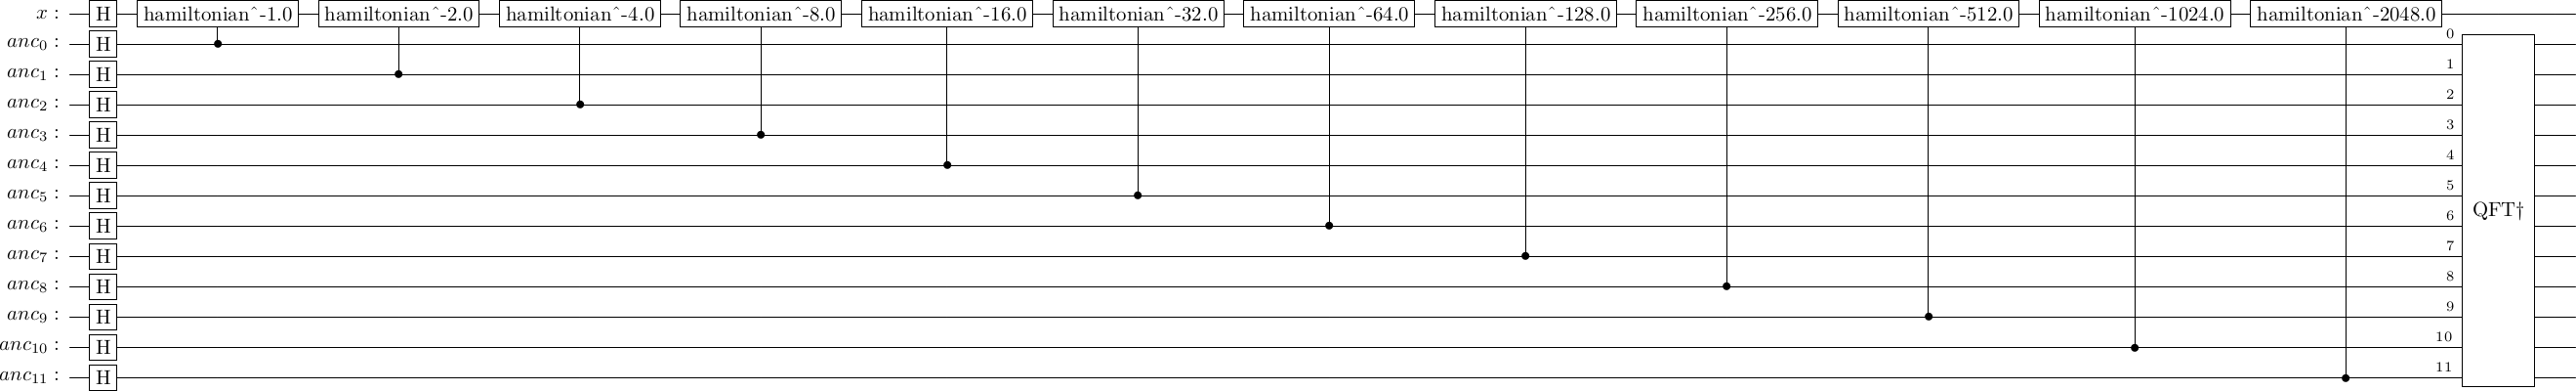

In [10]:
circ.draw('latex')

In [11]:
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
state_vector = np.asarray(result.get_statevector())

In [12]:
state_v = np.asarray(state_vector).reshape((2**nanc,2**nx)).T
state_v = np.sum(state_v, axis=0)
state_v = state_v/np.sqrt(np.sum(np.abs(state_v)**2))

In [13]:
xs = np.arange(2**nanc)/(t0*2**nanc)

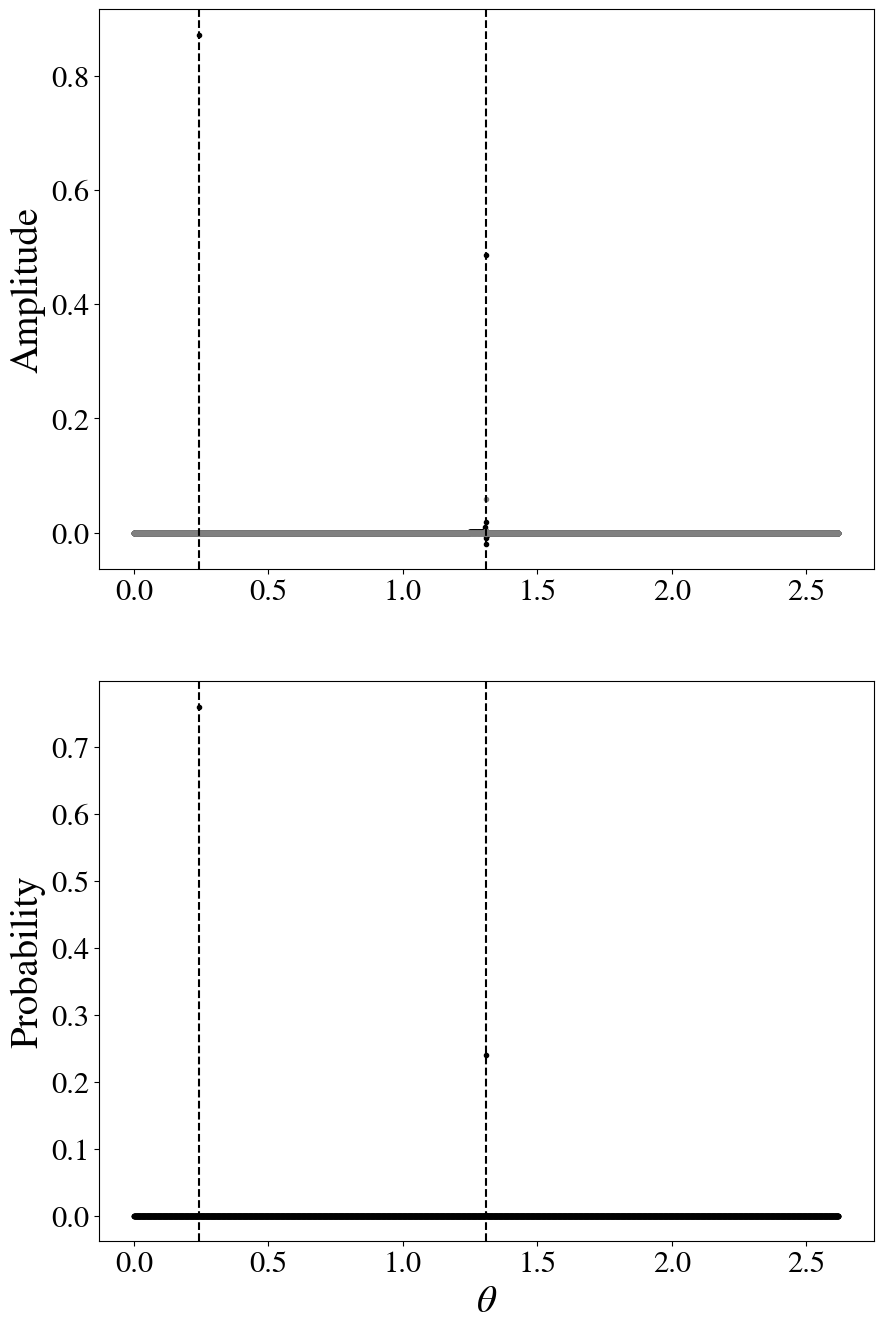

In [14]:
fig = plt.figure(figsize=np.array(figsize)*[1,2])
ax = fig.add_subplot(211)

plt.scatter(xs, state_v.real, marker='.', color='black')
plt.scatter(xs, state_v.imag, marker='.', color='grey')
ax.set_ylabel('Amplitude', fontsize=fontsize);
ax.tick_params(axis='both', labelsize=ticksize);

ax.axvline(lambda_min, ls='--', color='black')
ax.axvline(lambda_max, ls='--', color='black')

ax = fig.add_subplot(212)

plt.scatter(xs, np.abs(state_v)**2, marker='.', color='black')
ax.set_xlabel(r'$\theta$', fontsize=fontsize);
ax.set_ylabel('Probability', fontsize=fontsize);
ax.tick_params(axis='both', labelsize=ticksize);

ax.axvline(lambda_min, ls='--', color='black')
ax.axvline(lambda_max, ls='--', color='black')

plt.show()